

<h2>CIFAR-100</h2>

CIFAR-100  is a image classification dataset. 
+ Each data sample is an RGB $32\times32$ real image. A raw loaded image $\in \mathbb{R}^{3 \times 32 \times 32}$.
+ Each image is associated with a label $\in \{0,1,2,\dots, 99\}$.


Goal is to train a neural network classifier that takes such $3\times32\times32$ images and predict a label $\in \{0, 1, 2, \dots, 99\}$.

In [ ]:
# install dependencies

!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib inline

from typing import *

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dataclasses
from tqdm.auto import tqdm

import torchvision
from PIL import Image

import torch
import torch.nn as nn 
import torch.nn.functional as F

assert torch.cuda.is_available(), "Should use GPU-enabled colab"

device = torch.device('cuda:0')  # we will train with CUDA!


# Dataset



  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Training set size: 50000
Validation set size: 10000
CIFAR-100 classes: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sun

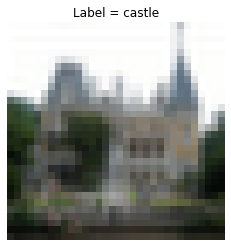

In [ ]:
#@title
%matplotlib inline

import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


def get_datasets(train_transforms=(), val_transforms=()):
    r"""
    Returns the CIFAR-100 training and validation datasets with corresponding 
    transforms.

    `*_transforms` represent optional transformations, e.g., conversion to
    PyTorch tensors, preprocessing, etc.
    """
    train_set = torchvision.datasets.CIFAR100(
        './data', train=True, download=True, 
        transform=torchvision.transforms.Compose(train_transforms)) 
    val_set = torchvision.datasets.CIFAR100(
        './data', train=False, download=True, 
        transform=torchvision.transforms.Compose(val_transforms)) 
    return train_set, val_set


cifar100_mean = torch.as_tensor([0.5071, 0.4865, 0.4409])
cifar100_std = torch.as_tensor([0.2673, 0.2564, 0.2762])

train_transforms = [
    torchvision.transforms.RandomCrop(32, padding=3, padding_mode='reflect'),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=cifar100_mean, std=cifar100_std),
]

val_transforms = [
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=cifar100_mean, std=cifar100_std),
]

train_set, val_set = get_datasets(train_transforms, val_transforms)

print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")

class_names = train_set.classes 
print(f'CIFAR-100 classes: {class_names}')

def visualize_tensor_data(data: torch.Tensor, label: int):
    # Data is a tensor of shape [C, W, H]  (C is the channel dimension, 3 for RGB)
    # Put channel at last
    data = data.permute(1, 2, 0)
    # Un-normalize
    data = data * cifar100_std + cifar100_mean

    plt.imshow(data)
    plt.axis('off')
    plt.title(f'Label = {class_names[label]}')

data, label = train_set[13]
visualize_tensor_data(data, label)

In [ ]:
from torch.nn.modules.activation import Tanh
from torch._C import Value
import torch.nn.functional as F

def make_cnn(num_outputs: int, activation: str, num_conv_layers: int = 4, num_fc_layers: int = 2) -> nn.Module:
    r'''
    Returns a PyTorch module representing a CNN network that takes in image-like input with shape [3, 32, 32].

    '''
    assert 3 <= num_conv_layers <= 5
    assert num_fc_layers >= 2
    assert activation in ['relu', 'tanh', 'none']
    class CNN(nn.Module):
        def __init__(self):
            super(CNN, self).__init__()

            func_d = {'relu': F.relu, 'tanh': F.tanh, 'none': lambda x: x}
            self.act = func_d[activation]
            self.conv_layers = nn.ModuleList()
            # no stride means stride = 1
            self.conv_layers.append(nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, padding_mode='reflect', padding=2, stride = 1))
            for k in range(num_conv_layers-1):
              if k == 0:
                self.conv_layers.append(nn.Conv2d(in_channels=12, out_channels=64, kernel_size=3, padding=1, stride=2))
              else:
                self.conv_layers.append(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=2))
            in_feature = (32 // (2 ** (num_conv_layers - 1))) ** 2 * 64
            self.fc_layers = nn.ModuleList()
            for k in range(num_fc_layers):
              if k == 0:
                self.fc_layers.append(nn.Linear(in_feature, 128))
              elif k == num_fc_layers - 1:
                self.fc_layers.append(nn.Linear(128, num_outputs))
              else:
                self.fc_layers.append(nn.Linear(128, 128))
        def forward(self, x):
            for i, conv_layer in enumerate(self.conv_layers):
              x = self.act(conv_layer(x))
              # print(i, x.shape, flush=True)
            
            x = torch.flatten(x, start_dim=1)
            # print(x.shape, flush=True)

            for i, fc_layer in enumerate(self.fc_layers):
                if i != len(self.fc_layers) - 1:
                    x = self.act(fc_layer(x))
                else:
                    x = fc_layer(x)
            return x
    return CNN()

In [ ]:
print('num_outputs=100, tanh, num_conv_layers=5, num_fc_layers=4:')
print(make_cnn(100, 'tanh', num_conv_layers=5, num_fc_layers=4))
print()
print('num_outputs=3, no activation, num_conv_layers=3, num_fc_layers=2:')
print(make_cnn(3, 'none', num_conv_layers=3, num_fc_layers=2))

num_outputs=100, tanh, num_conv_layers=5, num_fc_layers=4:
CNN(
  (conv_layers): ModuleList(
    (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=reflect)
    (1): Conv2d(12, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=100, bias=True)
  )
)

num_outputs=3, no activation, num_conv_layers=3, num_fc_layers=2:
CNN(
  (conv_layers): ModuleList(
    (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=reflect)
    (1): Conv2d(12, 64, kerne

## Training loop


In [ ]:
def train_epoch(epoch: int, model: nn.Module, train_loader: torch.utils.data.DataLoader, optim: torch.optim.Optimizer):
    r"""
    Trains `model` on `train_loader` for cross entropy loss for one epoch.

    Args:
        epoch (int): the current epoch number (i.e., number of epochs done before this one).
        model (nn.Module): our network (created using `make_cnn`).
        train_loader (DataLoader): a DataLoader that yields (batched_images, batched_target_class_indices) when iterated.
        optim (Optimizer): optimizer object that is created with `model` parameters and should be used for updating `model` in this function.

    Returns:
        (List[float]) the losses computed at each iteration as a list of *Python* numbers.

    """
    loss_values: List[float] = []  
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim
    for data, target in tqdm(train_loader, desc=f'Training @ epoch {epoch}'):
        data = data.to(device)  # flatten image data into batched vectors 
        target = target.to(device)
        # Clear out any previously computed gradient
        optimizer.zero_grad()
        # Forward pass the model
        # print(data.shape, flush=True)
        output = model(data)
        
        # Compute loss
        loss = loss_fn(output, target)
        
        loss_values.append(loss.item())
        
        # Backpropagate
        # dLdout = loss_fn.backward(torch.ones((), device=device))  # pass an explicit one because we are computing derivatives w.r.t. the loss itself
        
        loss.backward()
        optimizer.step()

    return loss_values


@dataclasses.dataclass
class EvaluateResult:
    r"""
    A collection containing everything we need to know about the evaluate results.

    See `evaluate` docstring for meanings of the members of this class
    """
    acc: float  # overall accuracy
    correct_predictions: torch.Tensor  # size |dataset|
    confidence: torch.Tensor  # size |dataset|


@torch.no_grad()
def evaluate(model: nn.Module, loader: torch.utils.data.DataLoader) -> EvaluateResult:
    r"""
    Evaluate a classifier `model` on dataset contained in `loader`.

    For each input, the predicted label is taken as one with highest probability in the distribution given by `model`.

    Args:
        model (nn.Module): our network (created using `make_cnn`).
        loader (DataLoader): a DataLoader that yields (batched_images, batched_target_class_indices) when iterated.

    Returns:
        (EvaluateResult) Containing overall accuracy, whether each sample is correctly classified, and confidence.
            The tensors should be on **CPU**.
    """

    correct_predcitions = 0
    correctness = []
    confidence = []
    for data, target in loader:
        data = data.to(device)  # flatten image data into batched vectors 
        
        target = target.to(device)

        output = model(data)
        pred = output.max(axis = 1)[1]
        correct_predcitions += (pred==target).sum().item()
        correctness.append(pred==target)
        confidence.append(output.max(axis = 1)[0])
        
    eveluateresult = EvaluateResult(correct_predcitions / len(loader.dataset),
                                   torch.cat(correctness, dim=0),
                                    torch.cat(confidence, dim=0) )
    return eveluateresult



@dataclasses.dataclass
class TrainResult:
    r"""
    A collection containing everything we need to know about the training results
    """
    num_epochs: int

    # Training loss (saved at each iteration in `train_epoch`)
    train_losses: List[float]

    # The epochs where we perform evaluation
    eval_epochs: List[int] 

    # Training accuracies, computed at each epoch in `eval_epochs`
    train_accs: List[float]
    
    # Validation accuracies, computed at each epoch in `eval_epochs`
    val_accs: List[float]

    # The last validation evaluation full result
    final_val_eval_result: EvaluateResult = None


def train(model: nn.Module, train_set, val_set, *, num_epochs=60, lr=0.003, train_epoch_fn=train_epoch, **kwargs):
    r"""
    Train `model` on `train_set` for `num_epochs` epochs using **Adam** optimizer and `lr` learning rate
    following a decay schedule by a factor of `0.3` at epochs `[40, 50]`.

    Args:
        model (nn.Module): our network (created using `make_cnn`).
        train_set (Dataset): CIFAR-100 training dataset.
        val_set (Dataset): CIFAR-100 validation dataset. Evaluated every *5* epochs and at the end of training.
        num_epochs (int): number of total training epochs.
        lr (float): initial learning rate.
        train_epoch_fn (Callable): function that trains the model for a single epoch. This is `train_epoch`
            usually, but we will use different choices in later questions.

    Returns:
        (TrainResult) 
    """
    # Data loaders
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=512, shuffle=True)  # Random order for training ("[S]tochastic" in SGD)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=1024, shuffle=False)

    # Our classifier
    print('Model =', model)

    # Create optimizer and lr scheduler
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[40,50], gamma=0.3) # not sure

    result: TrainResult = TrainResult(num_epochs, train_losses=[], eval_epochs=[], train_accs=[], val_accs=[])
    last_eval_epoch = -float('inf')

    # Iterate through the entire training dataset `num_epochs` times
    for epoch in range(num_epochs):
        if epoch - last_eval_epoch >= 5:
            result.eval_epochs.append(epoch)
            result.train_accs.append(evaluate(model, train_loader).acc)
            result.val_accs.append(evaluate(model, val_loader).acc)
            print(f"Epoch = {epoch:> 2d}    Train acc = {result.train_accs[-1]:.2%}    Val acc = {result.val_accs[-1]:.2%}")
            last_eval_epoch = epoch
        # Train over the entire `train_set` with given `train_epoch_fn` function (i.e., one epoch)
        result.train_losses.extend(train_epoch_fn(epoch, model, train_loader, optim, **kwargs))
        # Evaluate with our `evaluate` function
        print(f"Epoch = {epoch:> 2d}    Train loss = {result.train_losses[-1]:.4f}")

        # Adjust learning rate if needed
        scheduler.step()

    result.eval_epochs.append(num_epochs)
    result.train_accs.append(evaluate(model, train_loader).acc)
    result.final_val_eval_result = evaluate(model, val_loader)
    result.val_accs.append(result.final_val_eval_result.acc)
    print(f"Epoch = {num_epochs:> 2d}    Train acc = {result.train_accs[-1]:.2%}    Val acc = {result.val_accs[-1]:.2%}")

    return result

In [ ]:
def learning_curve(result: TrainResult, *, title: str = 'Learning Curve'):
    r"""
    Plot the training loss, training accuracy, and validation accuracy versus
    epochs taken.
    """
    fig, ax_loss = plt.subplots(figsize=(8, 5))
    ax_loss.set_title(title, fontsize=16)
    ax_loss.set_xlabel('Epoch', fontsize=12)

    l_trloss = ax_loss.plot(
        torch.arange(len(result.train_losses)) / len(result.train_losses) * result.num_epochs, 
        result.train_losses, 
        label='Train loss',
        color='C0',
    )
    ax_loss.set_ylim(0, 4.8)
    ax_loss.set_ylabel('Train loss', color='C0', fontsize=12)
    ax_loss.tick_params(axis='y', labelcolor='C0')

    ax_acc = ax_loss.twinx()
    l_tracc = ax_acc.plot(result.eval_epochs, result.train_accs, label='Train acc', color='C1', linestyle='--')
    if len(result.val_accs):
        l_valacc = ax_acc.plot(result.eval_epochs, result.val_accs, label='Val acc', color='C1')
    else:
        l_valacc = []
    ax_acc.set_ylim(0, 1)
    ax_acc.set_ylabel('Accuracies', color='C1', fontsize=12)
    ax_acc.tick_params(axis='y', labelcolor='C1')

    lines = l_trloss + l_tracc + l_valacc
    ax_loss.legend(lines, [l.get_label() for l in lines], loc='upper left', fontsize=13)

# Initialization



In [ ]:
@torch.no_grad()
def zeros_init_(model):
    r'''
    Args:
        model (nn.Module): network to be initialized

    Returns:
        same `model` object, after modifying its parameters in-place to be all zeros
    '''
    # FIXME
    for layer in list(model.conv_layers) + list(model.fc_layers):
      nn.init.zeros_(layer.weight)
      nn.init.zeros_(layer.bias)
    return model

Model = CNN(
  (conv_layers): ModuleList(
    (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=reflect)
    (1): Conv2d(12, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=100, bias=True)
  )
)
Epoch =  0    Train acc = 1.00%    Val acc = 1.00%


Training @ epoch 0:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  0    Train loss = 4.6059


Training @ epoch 1:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  1    Train loss = 4.6068


Training @ epoch 2:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  2    Train loss = 4.6063


Training @ epoch 3:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  3    Train loss = 4.6057


Training @ epoch 4:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  4    Train loss = 4.6065
Epoch =  5    Train acc = 1.00%    Val acc = 1.00%


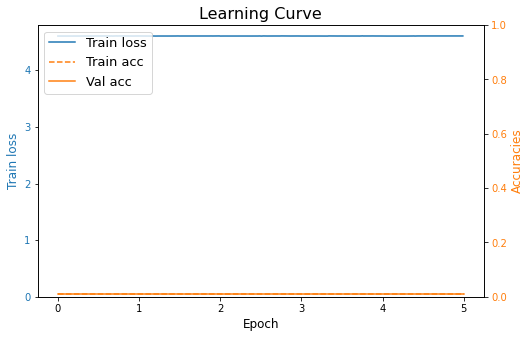

In [ ]:
zero_init_model = zeros_init_(make_cnn(100, 'relu').to(device))
zero_init_res = train(zero_init_model, train_set, val_set, num_epochs=5)
learning_curve(zero_init_res)

In [ ]:
zero_init_model

NameError: ignored

In [ ]:
# FIXME
first_conv = zero_init_model.conv_layers[0]   # the first conv layer of `zero_init_model`
print('After training, first layer bias = ', first_conv.bias)

After training, first layer bias =  Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


In [ ]:
@torch.no_grad()
def const_out_var_init_(model):
    r'''
    Args:
        model (nn.Module): network to be initialized

    Returns:
        same `model` object, after initializing its parameters in-place to ensure constant output variance

    Remember that biases should be initialized as zeros
    '''
    # FIXME
    for layer in model.conv_layers: # is weights from conv layers different?
      shape = layer.weight.shape #?? how to get input shape
      std = np.sqrt(1/(shape[1]*shape[2]*shape[3]))      
      nn.init.normal_(layer.weight,mean=0.0, std=std)
      nn.init.zeros_(layer.bias)

    for layer in model.fc_layers: # is weights from conv layers different?
      shape = layer.weight.shape #?? how to get input shape
      std = np.sqrt(1/(shape[1]))
    
      nn.init.normal_(layer.weight,mean=0.0, std=std)
      nn.init.zeros_(layer.bias)
    return model

In [ ]:
sampled_data = torch.normal(0,1,size = (1000,3,32,32)).to(device)
cons_init_model = const_out_var_init_(make_cnn(1, 'none', num_conv_layers=3, num_fc_layers=3).to(device))
cons_init_res1 = cons_init_model(sampled_data)

In [ ]:
cons_init_model = const_out_var_init_(make_cnn(1, 'none', num_conv_layers=4, num_fc_layers=5).to(device))
cons_init_res2 = cons_init_model(sampled_data)

In [ ]:
cons_init_model = const_out_var_init_(make_cnn(1, 'none', num_conv_layers=5, num_fc_layers=20).to(device))
cons_init_res3 = cons_init_model(sampled_data)

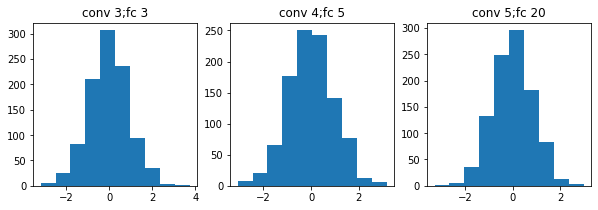

In [ ]:
fig,ax = plt.subplots(1,3, figsize = (10,3))
ax[0].hist(cons_init_res1.reshape(-1).detach().cpu())
ax[0].set_title('conv 3;fc 3')
ax[1].hist(cons_init_res2.reshape(-1).detach().cpu())
ax[1].set_title('conv 4;fc 5')
ax[2].hist(cons_init_res3.reshape(-1).detach().cpu())
ax[2].set_title('conv 5;fc 20')

plt.show()

Model = CNN(
  (conv_layers): ModuleList(
    (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=reflect)
    (1): Conv2d(12, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=100, bias=True)
  )
)
Epoch =  0    Train acc = 0.90%    Val acc = 0.83%


Training @ epoch 0:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  0    Train loss = 3.6451


Training @ epoch 1:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  1    Train loss = 3.0820


Training @ epoch 2:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  2    Train loss = 3.0964


Training @ epoch 3:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  3    Train loss = 3.0082


Training @ epoch 4:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  4    Train loss = 2.8129
Epoch =  5    Train acc = 30.40%    Val acc = 30.73%


Training @ epoch 5:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  5    Train loss = 2.7406


Training @ epoch 6:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  6    Train loss = 2.5436


Training @ epoch 7:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  7    Train loss = 2.4776


Training @ epoch 8:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  8    Train loss = 2.4815


Training @ epoch 9:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  9    Train loss = 2.3299
Epoch =  10    Train acc = 38.49%    Val acc = 37.32%


Training @ epoch 10:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  10    Train loss = 2.4937


Training @ epoch 11:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  11    Train loss = 2.3529


Training @ epoch 12:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  12    Train loss = 2.2701


Training @ epoch 13:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  13    Train loss = 2.1620


Training @ epoch 14:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  14    Train loss = 2.3855
Epoch =  15    Train acc = 42.92%    Val acc = 40.50%


Training @ epoch 15:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  15    Train loss = 2.1517


Training @ epoch 16:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  16    Train loss = 2.2033


Training @ epoch 17:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  17    Train loss = 2.0851


Training @ epoch 18:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  18    Train loss = 2.1402


Training @ epoch 19:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  19    Train loss = 1.8403
Epoch =  20    Train acc = 46.34%    Val acc = 43.29%


Training @ epoch 20:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  20    Train loss = 2.2258


Training @ epoch 21:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  21    Train loss = 1.8887


Training @ epoch 22:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  22    Train loss = 1.9598


Training @ epoch 23:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  23    Train loss = 1.9192


Training @ epoch 24:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  24    Train loss = 2.0308
Epoch =  25    Train acc = 48.00%    Val acc = 43.79%


Training @ epoch 25:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  25    Train loss = 1.8802


Training @ epoch 26:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  26    Train loss = 1.9569


Training @ epoch 27:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  27    Train loss = 1.9572


Training @ epoch 28:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  28    Train loss = 2.0685


Training @ epoch 29:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  29    Train loss = 1.8564
Epoch =  30    Train acc = 49.86%    Val acc = 45.08%


Training @ epoch 30:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  30    Train loss = 1.9316


Training @ epoch 31:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  31    Train loss = 2.0544


Training @ epoch 32:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  32    Train loss = 1.7643


Training @ epoch 33:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  33    Train loss = 1.8103


Training @ epoch 34:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  34    Train loss = 1.9032
Epoch =  35    Train acc = 49.58%    Val acc = 45.10%


Training @ epoch 35:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  35    Train loss = 1.8514


Training @ epoch 36:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  36    Train loss = 1.7995


Training @ epoch 37:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  37    Train loss = 2.1408


Training @ epoch 38:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  38    Train loss = 2.0621


Training @ epoch 39:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  39    Train loss = 1.7174
Epoch =  40    Train acc = 50.87%    Val acc = 46.62%


Training @ epoch 40:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  40    Train loss = 1.7720


Training @ epoch 41:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  41    Train loss = 1.6254


Training @ epoch 42:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  42    Train loss = 1.5747


Training @ epoch 43:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  43    Train loss = 1.6013


Training @ epoch 44:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  44    Train loss = 1.5603
Epoch =  45    Train acc = 55.94%    Val acc = 48.75%


Training @ epoch 45:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  45    Train loss = 1.7028


Training @ epoch 46:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  46    Train loss = 1.7403


Training @ epoch 47:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  47    Train loss = 1.6354


Training @ epoch 48:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  48    Train loss = 1.3610


Training @ epoch 49:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  49    Train loss = 1.3854
Epoch =  50    Train acc = 56.52%    Val acc = 48.83%


Training @ epoch 50:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  50    Train loss = 1.4451


Training @ epoch 51:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  51    Train loss = 1.5788


Training @ epoch 52:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  52    Train loss = 1.6582


Training @ epoch 53:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  53    Train loss = 1.4538


Training @ epoch 54:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  54    Train loss = 1.4353
Epoch =  55    Train acc = 58.19%    Val acc = 49.90%


Training @ epoch 55:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  55    Train loss = 1.3819


Training @ epoch 56:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  56    Train loss = 1.5001


Training @ epoch 57:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  57    Train loss = 1.5508


Training @ epoch 58:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  58    Train loss = 1.4044


Training @ epoch 59:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  59    Train loss = 1.5916
Epoch =  60    Train acc = 58.32%    Val acc = 50.37%


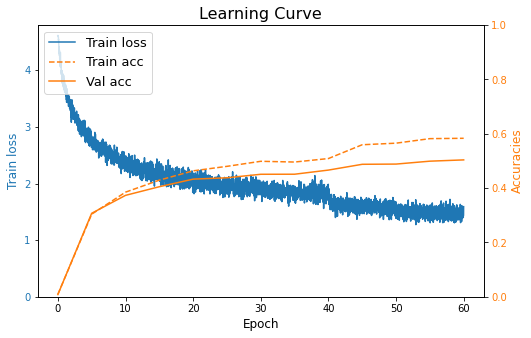

In [ ]:
model = const_out_var_init_(make_cnn(100, 'relu', num_conv_layers=4, num_fc_layers=3).to(device))
res = train(model, train_set, val_set)
learning_curve(res)

# Regularization


In [ ]:
def regularized_train_epoch(epoch: int, model: nn.Module, train_loader: torch.utils.data.DataLoader, optim: torch.optim.Optimizer,
                            lam: float, reg_choice: str):
    r"""
    Trains `model` on `train_loader` for cross entropy loss **AND l1 or l2 regularization** for one epoch.

    Args:
        epoch (int): the current epoch number (i.e., number of epochs done before this one).
        model (nn.Module): our network (created using `make_cnn`).
        train_loader (DataLoader): a DataLoader that yields (batched_images, batched_target_class_indices) when iterated.
        optim (Optimizer): optimizer object that is created with `model` parameters and should be used for updating `model` in this function.
    NEW Args:
        lam (float): regularizer weight.
        reg_choice (str): one of ['l1', 'l2'].

    Returns:
        (List[float]) the **cross entropy losses** computed at each iteration as a list of *Python* numbers.
    """

    loss_values: List[float] = []  
    flat_all_params = torch.cat([p.flatten() for p in model.parameters()])
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim
    for data, target in tqdm(train_loader, desc=f'Training @ epoch {epoch}'):
        # FIXME
        data = data.to(device)  # flatten image data into batched vectors 
        target = target.to(device)
        optimizer.zero_grad()


        # Forward pass the model
        output = model(data)
        
        # Compute loss
        loss = loss_fn(output, target)
        loss_values.append(loss.item())
        if reg_choice == 'l2':
          loss+= lam*(torch.linalg.vector_norm(flat_all_params, 2)**2)
        elif reg_choice == 'l1':
          loss+= lam*torch.linalg.vector_norm(flat_all_params, 1)  
        
        
        # Backpropagate
        # dLdout = loss_fn.backward(torch.ones((), device=device))  # pass an explicit one because we are computing derivatives w.r.t. the loss itself
                # Clear out any previously computed gradient
        
        loss.backward()
        optimizer.step()


    return loss_values

Model = CNN(
  (conv_layers): ModuleList(
    (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=reflect)
    (1): Conv2d(12, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=100, bias=True)
  )
)
Epoch =  0    Train acc = 1.07%    Val acc = 1.03%


Training @ epoch 0:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  0    Train loss = 3.7168


Training @ epoch 1:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  1    Train loss = 3.3139


Training @ epoch 2:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  2    Train loss = 3.0267


Training @ epoch 3:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  3    Train loss = 2.8627


Training @ epoch 4:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  4    Train loss = 2.6591
Epoch =  5    Train acc = 31.68%    Val acc = 32.71%


Training @ epoch 5:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  5    Train loss = 2.6775


Training @ epoch 6:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  6    Train loss = 2.5335


Training @ epoch 7:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  7    Train loss = 2.6536


Training @ epoch 8:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  8    Train loss = 2.3338


Training @ epoch 9:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  9    Train loss = 2.3514
Epoch =  10    Train acc = 39.45%    Val acc = 38.89%


Training @ epoch 10:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  10    Train loss = 2.2524


Training @ epoch 11:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  11    Train loss = 2.3548


Training @ epoch 12:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  12    Train loss = 2.2502


Training @ epoch 13:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  13    Train loss = 2.1771


Training @ epoch 14:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  14    Train loss = 2.0986
Epoch =  15    Train acc = 45.67%    Val acc = 43.62%


Training @ epoch 15:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  15    Train loss = 2.1090


Training @ epoch 16:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  16    Train loss = 2.0069


Training @ epoch 17:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  17    Train loss = 2.1177


Training @ epoch 18:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  18    Train loss = 2.1696


Training @ epoch 19:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  19    Train loss = 2.0932
Epoch =  20    Train acc = 47.74%    Val acc = 44.43%


Training @ epoch 20:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  20    Train loss = 2.0434


Training @ epoch 21:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  21    Train loss = 1.9862


Training @ epoch 22:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  22    Train loss = 1.9778


Training @ epoch 23:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  23    Train loss = 2.0022


Training @ epoch 24:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  24    Train loss = 2.0146
Epoch =  25    Train acc = 50.69%    Val acc = 46.26%


Training @ epoch 25:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  25    Train loss = 1.7661


Training @ epoch 26:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  26    Train loss = 1.7907


Training @ epoch 27:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  27    Train loss = 1.9389


Training @ epoch 28:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  28    Train loss = 1.8626


Training @ epoch 29:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  29    Train loss = 1.9083
Epoch =  30    Train acc = 51.78%    Val acc = 47.63%


Training @ epoch 30:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  30    Train loss = 1.7126


Training @ epoch 31:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  31    Train loss = 1.8471


Training @ epoch 32:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  32    Train loss = 1.8150


Training @ epoch 33:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  33    Train loss = 1.7333


Training @ epoch 34:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  34    Train loss = 1.8324
Epoch =  35    Train acc = 53.57%    Val acc = 48.90%


Training @ epoch 35:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  35    Train loss = 1.8020


Training @ epoch 36:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  36    Train loss = 1.7665


Training @ epoch 37:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  37    Train loss = 1.7541


Training @ epoch 38:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  38    Train loss = 1.7715


Training @ epoch 39:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  39    Train loss = 1.7839
Epoch =  40    Train acc = 54.99%    Val acc = 48.93%


Training @ epoch 40:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  40    Train loss = 1.4072


Training @ epoch 41:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  41    Train loss = 1.4133


Training @ epoch 42:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  42    Train loss = 1.4043


Training @ epoch 43:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  43    Train loss = 1.4509


Training @ epoch 44:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  44    Train loss = 1.3915
Epoch =  45    Train acc = 60.32%    Val acc = 51.53%


Training @ epoch 45:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  45    Train loss = 1.5045


Training @ epoch 46:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  46    Train loss = 1.2428


Training @ epoch 47:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  47    Train loss = 1.4247


Training @ epoch 48:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  48    Train loss = 1.6351


Training @ epoch 49:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  49    Train loss = 1.4012
Epoch =  50    Train acc = 60.46%    Val acc = 51.52%


Training @ epoch 50:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  50    Train loss = 1.2303


Training @ epoch 51:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  51    Train loss = 1.3853


Training @ epoch 52:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  52    Train loss = 1.4769


Training @ epoch 53:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  53    Train loss = 1.4386


Training @ epoch 54:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  54    Train loss = 1.2926
Epoch =  55    Train acc = 62.97%    Val acc = 52.73%


Training @ epoch 55:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  55    Train loss = 1.1906


Training @ epoch 56:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  56    Train loss = 1.2335


Training @ epoch 57:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  57    Train loss = 1.2950


Training @ epoch 58:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  58    Train loss = 1.4107


Training @ epoch 59:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  59    Train loss = 1.3208
Epoch =  60    Train acc = 63.13%    Val acc = 52.80%


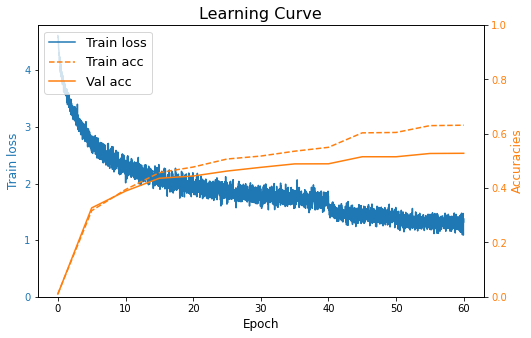

In [ ]:
model_l1 = const_out_var_init_(make_cnn(100, 'relu', num_conv_layers=4, num_fc_layers=3).to(device))
res_l1 = train(model_l1, train_set, val_set, train_epoch_fn=regularized_train_epoch, lam=3e-5, reg_choice='l1')
learning_curve(res_l1)

Model = CNN(
  (conv_layers): ModuleList(
    (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=reflect)
    (1): Conv2d(12, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=100, bias=True)
  )
)
Epoch =  0    Train acc = 1.03%    Val acc = 1.10%


Training @ epoch 0:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  0    Train loss = 3.7527


Training @ epoch 1:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  1    Train loss = 3.3674


Training @ epoch 2:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  2    Train loss = 2.9360


Training @ epoch 3:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  3    Train loss = 2.8550


Training @ epoch 4:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  4    Train loss = 2.8617
Epoch =  5    Train acc = 29.47%    Val acc = 29.45%


Training @ epoch 5:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  5    Train loss = 2.7032


Training @ epoch 6:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  6    Train loss = 2.6450


Training @ epoch 7:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  7    Train loss = 2.4291


Training @ epoch 8:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  8    Train loss = 2.3237


Training @ epoch 9:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  9    Train loss = 2.3111
Epoch =  10    Train acc = 39.29%    Val acc = 38.02%


Training @ epoch 10:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  10    Train loss = 2.3251


Training @ epoch 11:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  11    Train loss = 2.1746


Training @ epoch 12:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  12    Train loss = 2.2275


Training @ epoch 13:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  13    Train loss = 2.0950


Training @ epoch 14:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  14    Train loss = 2.3424
Epoch =  15    Train acc = 42.74%    Val acc = 40.58%


Training @ epoch 15:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  15    Train loss = 2.0219


Training @ epoch 16:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  16    Train loss = 2.2508


Training @ epoch 17:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  17    Train loss = 2.1369


Training @ epoch 18:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  18    Train loss = 2.0410


Training @ epoch 19:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  19    Train loss = 1.9899
Epoch =  20    Train acc = 46.02%    Val acc = 43.60%


Training @ epoch 20:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  20    Train loss = 2.0494


Training @ epoch 21:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  21    Train loss = 1.9401


Training @ epoch 22:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  22    Train loss = 1.9413


Training @ epoch 23:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  23    Train loss = 1.9739


Training @ epoch 24:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  24    Train loss = 1.9263
Epoch =  25    Train acc = 47.72%    Val acc = 44.91%


Training @ epoch 25:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  25    Train loss = 2.0406


Training @ epoch 26:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  26    Train loss = 1.8526


Training @ epoch 27:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  27    Train loss = 1.9569


Training @ epoch 28:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  28    Train loss = 1.7538


Training @ epoch 29:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  29    Train loss = 1.8234
Epoch =  30    Train acc = 48.44%    Val acc = 45.25%


Training @ epoch 30:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  30    Train loss = 1.9948


Training @ epoch 31:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  31    Train loss = 1.9056


Training @ epoch 32:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  32    Train loss = 1.7371


Training @ epoch 33:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  33    Train loss = 2.0345


Training @ epoch 34:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  34    Train loss = 1.6843
Epoch =  35    Train acc = 51.94%    Val acc = 47.26%


Training @ epoch 35:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  35    Train loss = 1.9108


Training @ epoch 36:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  36    Train loss = 1.8585


Training @ epoch 37:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  37    Train loss = 1.8450


Training @ epoch 38:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  38    Train loss = 1.9644


Training @ epoch 39:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  39    Train loss = 1.9025
Epoch =  40    Train acc = 52.32%    Val acc = 47.18%


Training @ epoch 40:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  40    Train loss = 1.6868


Training @ epoch 41:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  41    Train loss = 1.5627


Training @ epoch 42:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  42    Train loss = 1.5785


Training @ epoch 43:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  43    Train loss = 1.5625


Training @ epoch 44:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  44    Train loss = 1.5434
Epoch =  45    Train acc = 57.49%    Val acc = 50.38%


Training @ epoch 45:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  45    Train loss = 1.6992


Training @ epoch 46:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  46    Train loss = 1.5153


Training @ epoch 47:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  47    Train loss = 1.3912


Training @ epoch 48:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  48    Train loss = 1.4537


Training @ epoch 49:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  49    Train loss = 1.6129
Epoch =  50    Train acc = 58.02%    Val acc = 50.54%


Training @ epoch 50:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  50    Train loss = 1.4843


Training @ epoch 51:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  51    Train loss = 1.3890


Training @ epoch 52:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  52    Train loss = 1.3295


Training @ epoch 53:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  53    Train loss = 1.3443


Training @ epoch 54:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  54    Train loss = 1.4959
Epoch =  55    Train acc = 59.85%    Val acc = 51.60%


Training @ epoch 55:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  55    Train loss = 1.3857


Training @ epoch 56:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  56    Train loss = 1.4345


Training @ epoch 57:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  57    Train loss = 1.2711


Training @ epoch 58:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  58    Train loss = 1.4486


Training @ epoch 59:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch =  59    Train loss = 1.4386
Epoch =  60    Train acc = 60.44%    Val acc = 51.76%


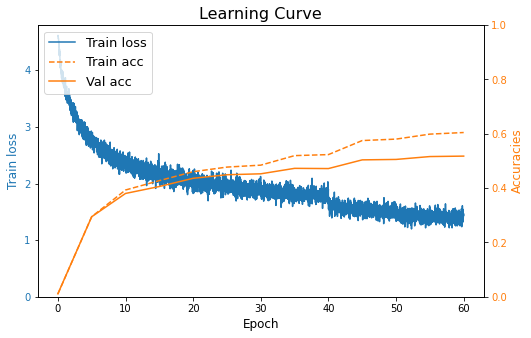

In [ ]:
model_l2 = const_out_var_init_(make_cnn(100, 'relu', num_conv_layers=4, num_fc_layers=3).to(device))
res_l2 = train(model_l2, train_set, val_set, train_epoch_fn=regularized_train_epoch, lam=3e-5, reg_choice='l2')
learning_curve(res_l2)

In [ ]:
from torch.nn.modules import L1Loss

# Make the histogram plot

lnone = []
for layer in list(model.fc_layers) +list(model.conv_layers):
  lnone.append(layer.weight.detach().cpu().reshape(-1))
l1 = []
for layer in list(model_l1.fc_layers) +list(model_l1.conv_layers):
  l1.append(layer.weight.detach().cpu().reshape(-1))

model = model_l2
l2 = []
for layer in list(model_l2.fc_layers) +list(model_l2.conv_layers):
  l2.append(layer.weight.detach().cpu().reshape(-1))

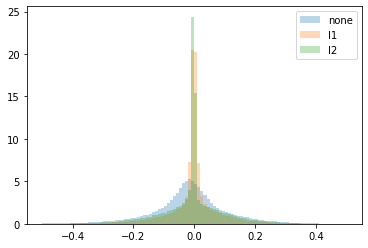

In [ ]:
plt.hist([item for sublist in lnone for item in sublist],bins = 100,range = [-0.5,0.5],alpha = 0.3,label = 'none',density = True)

plt.hist([item for sublist in l1 for item in sublist],bins = 100,range = [-0.5,0.5],alpha = 0.3,label = 'l1',density = True)

plt.hist([item for sublist in l2 for item in sublist],bins = 100,range = [-0.5,0.5],alpha = 0.3,label = 'l2',density = True)
plt.legend()
plt.show()